<a href="https://colab.research.google.com/github/mountechsolutions/stock-price-forecasting/blob/master/Apple_Stock_Price_Pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


In [41]:
df = web.DataReader('AAPL', data_source='yahoo', start='2000-01-01', end='2020-08-01') 

In [42]:
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,4.017857,3.631696,3.745536,3.997768,133949200.0,3.460857
2000-01-04,3.950893,3.613839,3.866071,3.660714,128094400.0,3.169071
2000-01-05,3.948661,3.678571,3.705357,3.714286,194580400.0,3.215448
2000-01-06,3.821429,3.392857,3.790179,3.392857,191993200.0,2.937188
2000-01-07,3.607143,3.410714,3.446429,3.553571,115183600.0,3.076317


In [43]:
df.shape

(5178, 6)

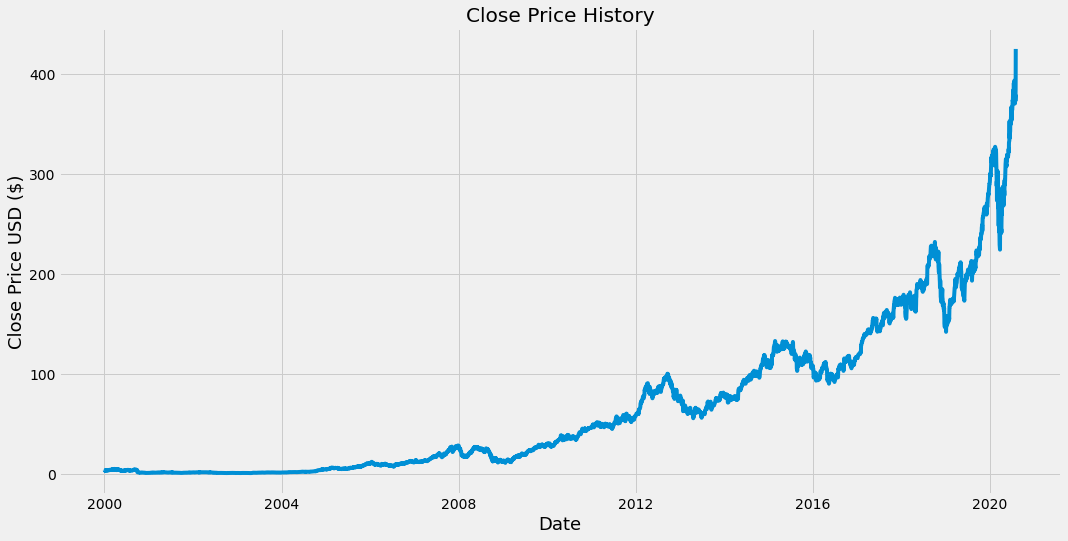

In [44]:
#Visualize the closing price history
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price USD ($)',fontsize=18)
plt.show()

In [45]:
#Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
#Converting the dataframe to a numpy array
dataset = data.values

In [46]:
data.head(-5)

,Close
Date,
2000-01-03,3.997768
2000-01-04,3.660714
2000-01-05,3.714286
2000-01-06,3.392857
2000-01-07,3.553571
...,...
2020-07-20,393.429993
2020-07-21,388.000000
2020-07-22,389.089996


In [47]:
#Get /Compute the number of rows to train the model on
training_data_len = math.ceil( len(dataset) *.8) 
training_data_len

4143

In [48]:
# Normalize
scaler = MinMaxScaler(feature_range=(0, 1))
norm_val = scaler.fit_transform(dataset)

In [49]:
train_data = norm_val[0:training_data_len  , : ]
print(train_data.shape)

(4143, 1)


In [50]:
x_train = []
y_train = []

for i in range(70, len(train_data)):
  x_train.append(train_data[i-70:i, 0])
  y_train.append(train_data[i, 0])

In [51]:
print(len(x_train), len(y_train))

4073 4073


In [52]:
type(x_train)

list

In [53]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [54]:
x_train.shape

(4073, 70)

### LSTM

In [55]:
# Converting into 3D array
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [56]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 70, 50)            10400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


In [57]:
model.compile(optimizer='adam', loss='mean_squared_error',)

In [58]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

Epoch 1/1
4073/4073 [==============================] - 940s 231ms/step - loss: 1.3336e-04


In [59]:
#Test data set
test_data = norm_val[training_data_len - 70: , : ]
#Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] #Get all of the rows from index 1603 to the rest and all of the columns (in this case it's only column 'Close'), so 2003 - 1603 = 400 rows of data
for i in range(70,len(test_data)):
    x_test.append(test_data[i-70:i,0])

In [60]:
x_test = np.array(x_test)

In [61]:
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [62]:
#Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)#Undo scaling

In [63]:
#Calculate/Get the value of RMSE
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

14.606107451047006

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


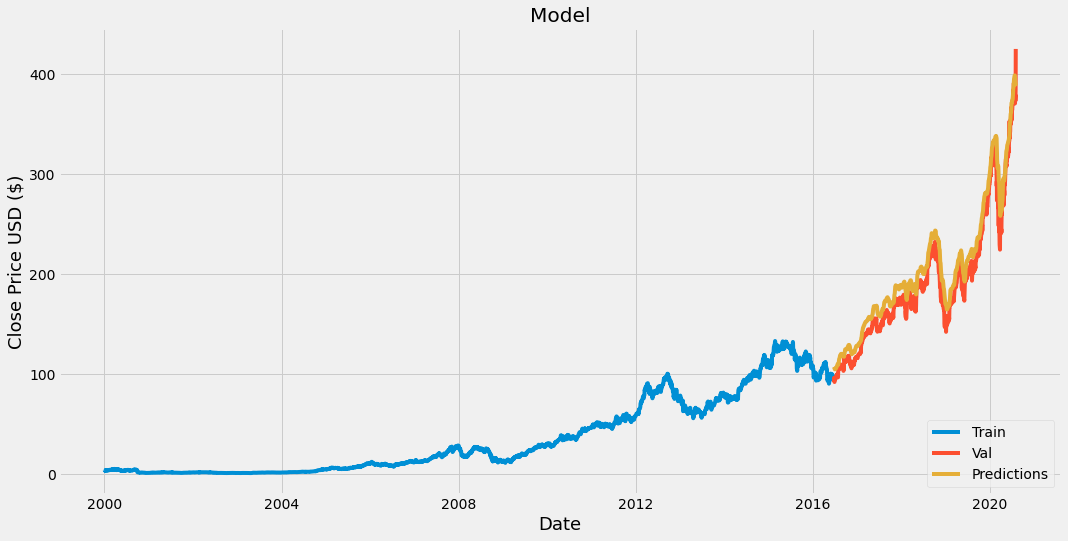

In [64]:
#Plot/Create the data for the graph
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [65]:
valid

,Close,Predictions
Date,,
2016-06-22,95.550003,107.118858
2016-06-23,96.099998,106.794739
2016-06-24,93.400002,106.626709
2016-06-27,92.040001,106.152878
2016-06-28,93.589996,105.418419
...,...,...
2020-07-27,379.239990,393.383057
2020-07-28,373.010010,391.793457
2020-07-29,380.160004,390.022491


In [66]:
#Get the quote
apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2019-12-17')
#Create a new dataframe
new_df = apple_quote.filter(['Close'])
#Get teh last 60 day closing price 
last_60_days = new_df[-70:].values
#Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
#Append teh past 60 days
X_test.append(last_60_days_scaled)
#Convert the X_test data set to a numpy array
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
#Get the predicted scaled price
pred_price = model.predict(X_test)
#undo the scaling 
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[290.25696]]


In [67]:
#Get the quote
apple_quote2 = web.DataReader('AAPL', data_source='yahoo', start='2019-12-18', end='2019-12-18')
print(apple_quote2['Close'])

Date
2019-12-18    279.73999
Name: Close, dtype: float64


### Auto ARIMA

In [9]:
!pip install pyramid-arima

     |████████████████████████████████| 604kB 4.7MB/s 


In [10]:
from pyramid.arima import auto_arima

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/pyramid/__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision 

In [11]:
data = df.sort_index(ascending=True, axis=0)

train = data[:training_data_len]
valid = data[training_data_len:]

In [13]:
training = train['Close']
validation = valid['Close']

model = auto_arima(training, start_p=1, start_q=1,max_p=3, max_q=3, m=12,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(training)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=7015.742, BIC=7042.978, Fit time=16.886 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=8110.383, BIC=8121.278, Fit time=0.121 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=7625.596, BIC=7647.385, Fit time=3.224 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=7015.613, BIC=7037.401, Fit time=17.346 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=7017.124, BIC=7044.360, Fit time=13.574 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=8109.834, BIC=8126.176, Fit time=0.759 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=7017.082, BIC=7044.318, Fit time=36.575 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=7016.238, BIC=7048.921, Fit time=56.210 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=7015.529, BIC=7031.870, Fit time=8.595 seconds
Fit ARIMA: order=(0, 1,

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(0, 1, 0),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(0, 1, 1, 12), solver='lbfgs', start_params=None,
      suppress_warnings=True, transparams=True, trend='c')

In [15]:
forecast = model.predict(n_periods=431)
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

In [16]:
rms=np.sqrt(np.mean(np.power((np.array(valid['Close'])-np.array(forecast['Prediction'])),2)))
rms

52.9018966502722

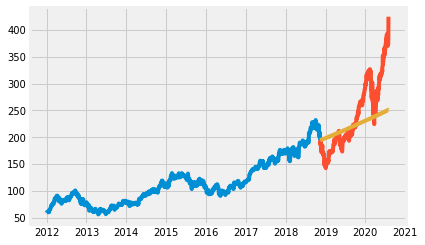

In [17]:
plt.plot(train['Close'])
plt.plot(valid['Close'])
plt.plot(forecast['Prediction'])

Test

In [20]:
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

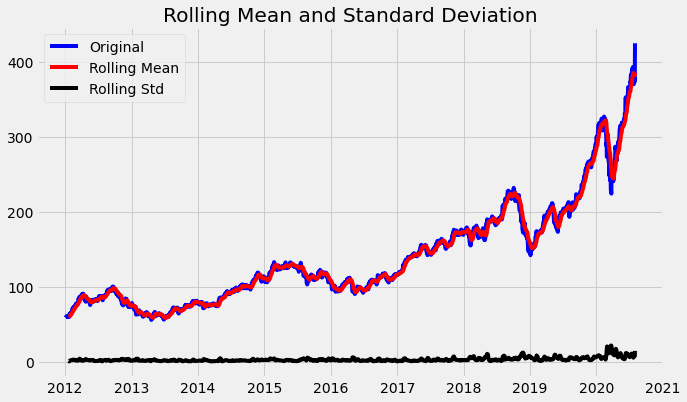

Results of dickey fuller test
Test Statistics                   2.173245
p-value                           0.998860
No. of lags used                 26.000000
Number of observations used    2132.000000
critical value (1%)              -3.433421
critical value (5%)              -2.862897
critical value (10%)             -2.567492
dtype: float64


In [26]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df['Close'])

<Figure size 720x432 with 0 Axes>

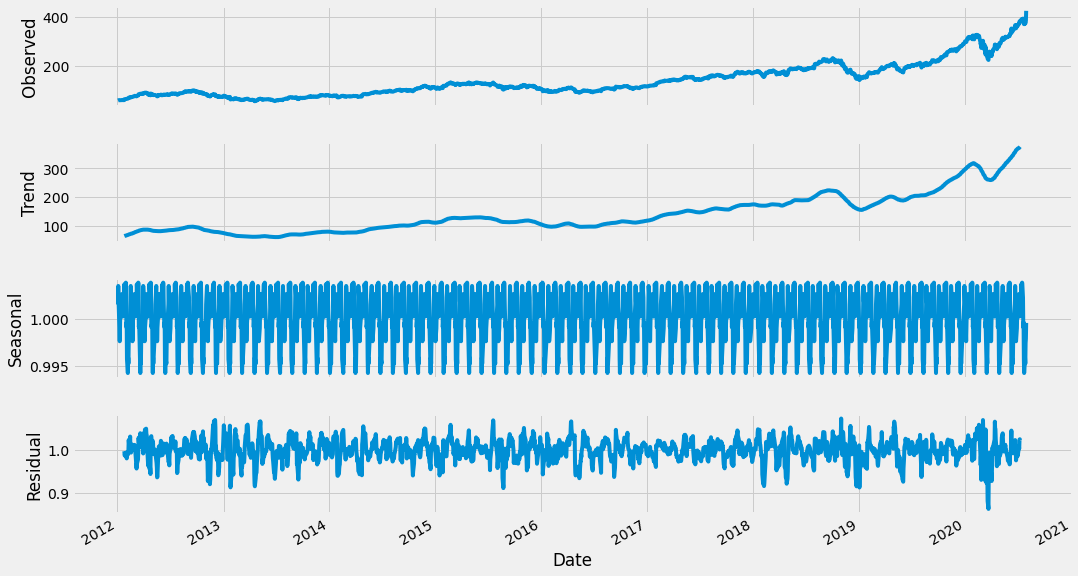

In [27]:
result = seasonal_decompose(df['Close'], model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


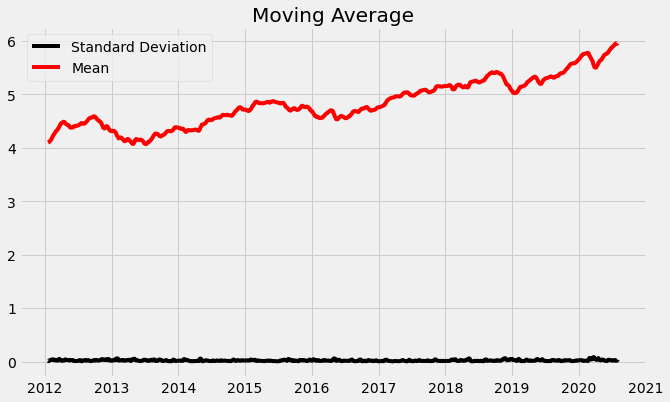

In [28]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

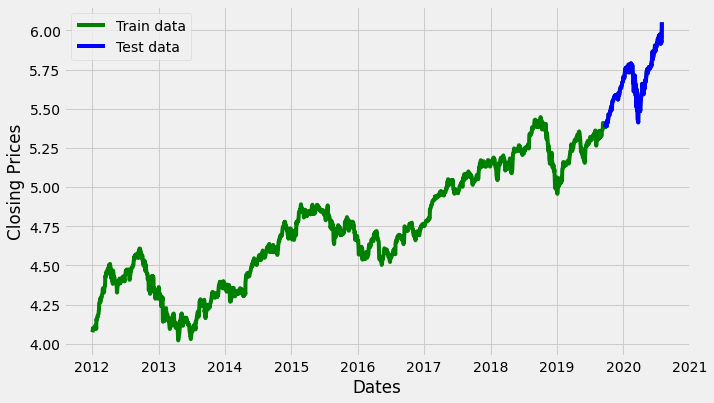

In [29]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [34]:
from statsmodels.tsa.arima_model import ARIMA


In [35]:
model = ARIMA(train_data, order=(3, 1, 2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1939
Model:                 ARIMA(3, 1, 2)   Log Likelihood                5239.114
Method:                       css-mle   S.D. of innovations              0.016
Date:                Sun, 02 Aug 2020   AIC                         -10464.228
Time:                        04:58:34   BIC                         -10425.239
Sample:                             1   HQIC                        -10449.890
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0007      0.000      1.796      0.073   -6.06e-05       0.001
ar.L1.D.Close    -1.2792      0.041    -31.020      0.000      -1.360      -1.198
ar.L2.D.Close    -0.9335      0.059    -

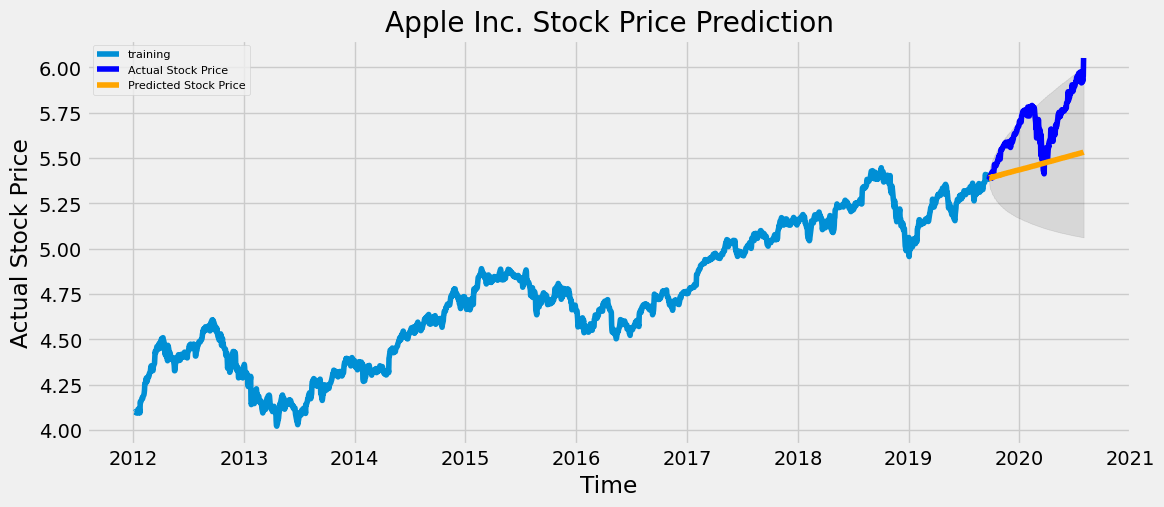

In [40]:
# Forecast
fc, se, conf = fitted.forecast(216, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Apple Inc. Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))


MSE: 0.06102105826855184
MAE: 0.2154594700036735
RMSE: 0.24702440824451302
MAPE: 0.037430684809742806
